In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
import matplotlib

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
class TrainExperimentShowResilience(TrainExperiment):
    def __init__(self, x_train, y_train, x_test, y_test, N, p_inference = None, p_train = None, KLips = 1, epochs = 20, activation = 'sigmoid', reg_type = None, reg_coeff = 0.01, do_print = False, name = 'exp', seed = 0, batch_size = 10000, exp_skip = 10, repetitions = 1000):
        """ Get a trained with MSE loss network with configuration (N, P, activation) and reg_type(reg_coeff) with name. The last layer is linear
                N: array with shapes [hidden1, hidden2, ..., hiddenLast]. Input and output shapes are determined automatically
                p_inference: array with [p_input, p_h1, ..., p_hlast, p_output]: inference failure probabilities
                Ptrain: same for the train
                Computes v4 bound and experimental bound during training
        """

        # fixing Pinference
        if p_inference == None:
            p_inference = [0] * (len(N) + 2)

        # fixing Ptrain
        if p_train == None:
            p_train = [0] * (len(N) + 2)

        # obtaining input/output shape
        input_shape = x_train[0].size
        output_shape = y_train[0].size

        # full array of shapes
        N = [input_shape] + N + [output_shape]

        # input check
        assert len(p_inference) == len(p_train), "Pinference and p_train must have the same length"
        assert len(N) == len(p_train), "Ptrain must have two more elements compared to N"
        assert input_shape > 0, "Input must exist"
        assert output_shape > 0, "Output must exist"

        # filling in the task
        self.task = 'regression'

        # remembering the dataset
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        
        # seeding the weights generation
        np.random.seed(seed)

        # creating weight initialization
        W, B = [], []
        for i in range(1, len(N)):
            W += [np.random.randn(N[i], N[i - 1]) * np.sqrt(2. / N[i - 1]) / KLips]
            B += [np.random.randn(N[i])]

        # creating a model
        model = create_fc_crashing_model(N, W, B, p_train, KLips = KLips, func = activation, reg_type = reg_type, reg_coeff = reg_coeff, do_print = do_print,
                                        loss = keras.losses.mean_absolute_error, optimizer = keras.optimizers.Adadelta())
        
        # creating "crashing" and "normal" models
        Experiment.__init__(self, N, W, B, p_inference, KLips = KLips, activation = activation, do_print = False, name = name)
        
        # mean error over the dataset on crashes at the first layer (too slow)
        mean_error_dLdy_exp = []
        
        # mean error (first order bound in p)
        mean_error_dLdy_v3 = []
        mean_error_dLdy_v4 = []
        
        # loss during training
        losses = []
        
        # will contain (w, dLdw)
        wdLdw = []
        
        # w of second layer
        w = self.model_correct.layers[1].weights[0]
        
        # output of the whole network
        y = self.model_correct.layers[-1].output
        
        # correct outputs
        y_train_t = tf.placeholder(tf.float32, shape=(None, 1), name = 'y_train')
        self.y_train_t = y_train_t
        
        # loss
        loss = tf.reduce_mean(tf.abs(y - y_train_t))
        
        # dloss/dW
        dLdw_t = tf.gradients([loss], [w])[0]
        
        # should be equal to E_x Delta * partialL/partialy
        wdLdw_t = tf.reduce_sum(tf.multiply(w, dLdw_t))
        
        # sanity check
        assert self.model_correct.loss == keras.losses.mean_squared_error, "Only support MAE now"
        
        def evaluate(tensor):
            """ Evaluate tensor on x_train """
            return self.run_on_input_and_output({'tmp': tensor}, x_train, y_train)['tmp']
        
        # training one epoch at a time
        for epoch in tqdm(range(epochs)):
            current_history = model.fit(x_train, y_train, verbose = False, batch_size = 1000, epochs = 1, validation_data = (x_test, y_test)).history
            
            # updating weights...
            self.model_crashing.set_weights(model.get_weights())
            self.model_correct.set_weights(model.get_weights())
            
            # adding mean error
            losses += [np.mean(np.abs(evaluate(y) - y_train))]
            
            # computing dL/dy
            dLdy = np.sign(evaluate(y).flatten() - y_train.flatten())
            
            # adding mean bound
            mean_bound_v3 = self.get_bound_v3(x_train)['mean'].flatten()
            mean_error_dLdy_v3 += [np.mean(np.multiply(mean_bound_v3, dLdy))]
            
            mean_bound_v4 = self.get_bound_v4(x_train)['mean'].flatten()
            mean_error_dLdy_v4 += [np.mean(np.multiply(mean_bound_v4, dLdy))]
            
            # evaluating the bound...
            wdLdw += [evaluate(wdLdw_t)]
            
            # adding experimental mean occasionally
            if epoch % exp_skip == 0:
                # mean over repetitions
                mean_exp = np.mean(self.compute_error(x_train, repetitions = repetitions), axis = 1).flatten()
                
                # mean over objects of error * dLdy
                mean_error_dLdy_exp += [(epoch, np.mean(np.multiply(mean_exp, dLdy)))]

        # saving the data
        self.losses = losses
        self.mean_error_dLdy_v3 = mean_error_dLdy_v3
        self.mean_error_dLdy_v4 = mean_error_dLdy_v4
        self.mean_error_dLdy_exp = mean_error_dLdy_exp
        self.wdLdw = wdLdw
        
    def run_on_input_and_output(self, tensors, data, outputs):
      """ Run dict of tensors on input data """
      self.check_input_shape(data)

      # list of all keys, fixed order
      keys = list(tensors.keys())

      # running for all keys
      results = get_session().run([tensors[key] for key in keys], feed_dict = {self.model_correct.layers[0].input.name: data,
                                                                              self.y_train_t.name: np.array(outputs).reshape(-1, 1)})

      # returning the result
      return {key: val for key, val in zip(keys, results)}

In [3]:
# get Boston data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [4]:
# Train some network

# network shape (w/o input-output)
N = [20, 19]
p = 1e-2
p_inference = [0, p] + [0] * len(N)
p_train = [0] * (len(N) + 2)

exp = TrainExperimentShowResilience(x_train, y_train, x_test, y_test, N, epochs = 300,
                                    p_inference = p_inference, p_train = p_train, activation = 'sigmoid',
                                    do_print = True, exp_skip = 50, repetitions = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                280       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                399       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 20        
Total params: 699
Trainable params: 699
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 300/300 [00:52<00:00, 21.14it/s]


/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


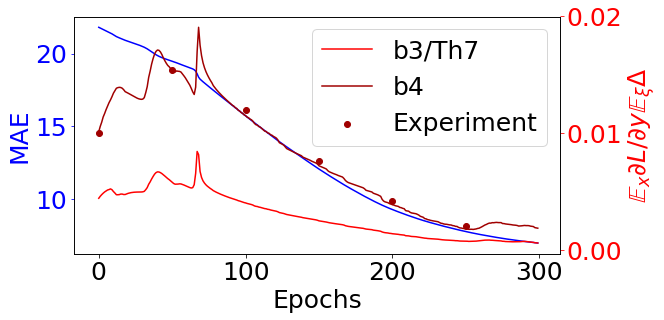

In [9]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

# show data
self = exp

fig, ax1 = plt.subplots(figsize=(10, 5))
#ax1.set_title('MAE and fault tolerance, Boston dataset')

ax1.plot(self.losses, 'b-', label = 'Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax4 = ax1.twinx()
ax2.set_ylabel('$\mathbb{E}_x\partial L/\partial y\mathbb{E}_\\xi \Delta$', color = 'r')
ax2.plot(self.mean_error_dLdy_v3, '-', label = 'b3/Th7', color = 'r')
ax2.plot(self.mean_error_dLdy_v4, label = 'b4', color = '#a00000')
ax2.tick_params('y', colors='r')
ax2.scatter(*zip(*self.mean_error_dLdy_exp), label = 'Experiment', color = '#a00000')

#ax3.spines["right"].set_position(("axes", 1.1))
#ax3.set_ylabel('$\mathbb{E}_x dy/dw$', color = 'g')
#ax3.plot(self.mean_dydw, label = 'Mean dy/dw', color = 'g')
#ax3.tick_params('y', colors = 'g')

#ax2.plot(-p * np.array(self.wdLdw), '--', label = 'Theorem 2', color = 'y')

#ax2.set_ylim(*[fcn(self.mean_error_dLdy_v4) for fcn in [np.min, np.max]])

ax2.legend()
fig.tight_layout()
fig.show()
fig.savefig('figures/training_boston_loss_error.pdf', bbox_inches = 'tight')
#plt.show()